In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from behavioural_benchmark.visualisation import Visualisation

In [2]:
results = pd.read_csv("../../Results/characteristicTest/results.csv", names=["experiment", "dim", "population_size", "iterations", "function", "metaheuristic", "control_params"] + [f"col_{i}" for i in range(26)])

In [3]:
vis = Visualisation(results)

In [4]:
columns = ['col_1']
metaheuristics = ['VonNeumannPSO', 'RingPSO', 'GBestPSO']
function = ['Weierstrass']
filter = {"metaheuristic": metaheuristics, "function": function}

In [5]:
vis.__prep_data__(columns=columns, filters=filter, exclude_outliers=True, normalise=True)

,metaheuristic,col_1
0,VonNeumannPSO,0.564552
1,VonNeumannPSO,0.863402
2,VonNeumannPSO,0.593765
3,VonNeumannPSO,0.403020
4,VonNeumannPSO,0.581713
...,...,...
595,GBestPSO,0.487294
596,GBestPSO,0.327468
597,GBestPSO,0.223766
598,GBestPSO,0.438076


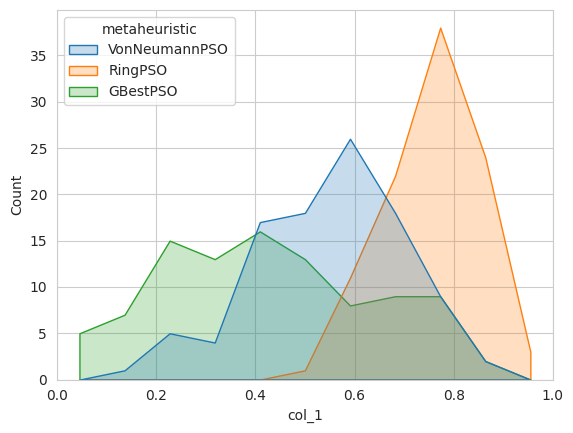

In [6]:
vis.cartesian_visualisation(columns=columns, filters=filter, exclude_outliers=True, normalise=True)

<Axes: xlabel='col_1', ylabel='col_2'>

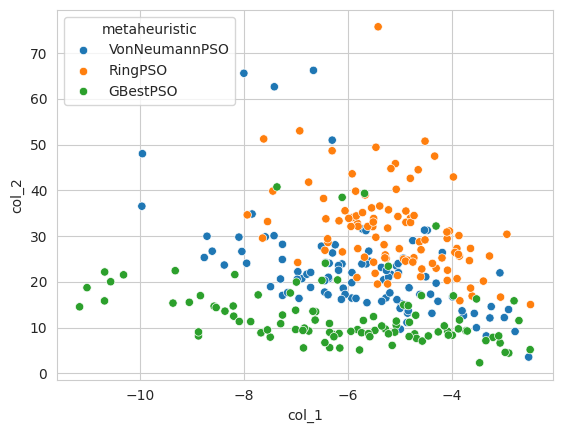

In [9]:
df = results[results['metaheuristic'].isin(metaheuristics)]
df = df[df['function'] == "Qing"]
sns.scatterplot(data=df, x='col_1', y='col_2', hue='metaheuristic')